## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

**Imports:**

In [1]:
import pandas as pd
#https://stackoverflow.com/questions/16424493/pandas-setting-no-of-max-rows
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
df.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

**Answer:**
There are several relationships that would be interesting to examine:
1. Is there any relationship between age and hemoglobin, white blood cell count, or red blood cell count? 
2. For those respondents who answered 'yes' to 'dm - diabetes mellitus' (having diabetes), is there any relationship between that yes and high blood pressure, hypertension, or coronary attery disease
    - The article confirms that screening for two of these facts can lead to positive diagnosis of kidney disease: 'Often, chronic kidney disease is diagnosed as a result of screening of people known to be at risk of kidney problems, such as those with high blood pressure or diabetes
3. Is there any association between 'pe		-	pedal edema' and 'wc		-	white blood cell count'

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [4]:
df.shape

(400, 25)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [6]:
df.isna().sum().sort_values(ascending = False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [7]:
df_nona = df.dropna()
df_nona.shape

(158, 25)

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [8]:
#note to self, how to determine if data missing is MCAR? missing at random basically ...

**Answer:**
There would be 158 rows remaining in the dataframe. One downside of the 'complete case analysis' approach is that we have dropped more than half our dataset's rows. A second downside is that we have no way of knowing if the information we dropped was missing at random or not, we may have introduced bias by taking this approach.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

**Answer:**
1. One type of potential errors are entry errors or human error. Numbers can be transposed accidentally or notes written down by a another individual could be misread. 
2. Another type of error could manifest if the measurements weren't being taken at consistent times of days for all patients. For example, it would make sense that people have elevated blood sugar after eating. If some measurements aren't being taken under the same circumstances, it could lead to inaccurate data. 
3. A third type of error that could potentially occur would be inaccurate data due to issue with equipment taking measurements. If an EKG is producing skewed results because of issues with the equipment itself, the data gathered would be contaminated. 

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

**Answer:**
You could construct a null model where the assumption is that everyone has CKD. You may misdiagnose some individuals that don't have CKD but you will never tell someone with CKD that they don't have it under that assumption. 

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

**Answer:**
Since we're creating a mdoel that will never tell someone with CKD that they don't have CKD, we are minimizing the false negative, type II error. We optimized for sensitivty or recall (also known as true positive rate). 

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

**Answer:**
The model will produce false positives, cases where people don't have CKD but we have told them that they do. These people will likely go seek treatment, spending time and money that they shouldn't have to. 

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

**Answer:**
Contrary to 6. you could just tell everyone that they don't have CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

**Answer:**
In this instance we optimized for specifity or selectivity (true negative rate). We minimized the false positive rate.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

**Answer:**
A huge disadvantage to the model described in 9. is that we would be telling everyone, even people who truly do have CKD, that they don't. Those people will not know to seek treatment and their conditions may worsen. 

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [9]:
df.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd


In [10]:
df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [11]:
df_logreg = df.drop(labels = ['bp', 'sg', 'al', 'su', 'pc',
                              'pcc', 'ba', 'bgr', 'bu', 
                              'sc', 'sod', 'pot', 'pcv', 'htn',
                              'dm', 'cad', 'appet', 'pe',
                              'ane'], axis = 1)

In [12]:
df_logreg.head(3)

,age,rbc,hemo,wbcc,rbcc,class
0,48.0,NaN,15.4,7800.0,5.2,ckd
1,7.0,NaN,11.3,6000.0,NaN,ckd
2,62.0,normal,9.6,7500.0,NaN,ckd


In [13]:
df_logreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   rbc     248 non-null    object 
 2   hemo    348 non-null    float64
 3   wbcc    294 non-null    float64
 4   rbcc    269 non-null    float64
 5   class   400 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.9+ KB


In [14]:
df_logreg.isna().sum().sort_values(ascending = False)

rbc      152
rbcc     131
wbcc     106
hemo      52
age        9
class      0
dtype: int64

In [15]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
df_logreg.dropna(subset = ['age'], inplace = True)

In [16]:
df_logreg['age'].isna().sum()

0

In [17]:
df_logreg['rbc'].value_counts()

normal      200
abnormal     44
Name: rbc, dtype: int64

In [18]:
df_logreg['rbc'].fillna('not recorded', inplace = True)

In [19]:
df_logreg['rbc'].value_counts()

normal          200
not recorded    147
abnormal         44
Name: rbc, dtype: int64

In [20]:
df_logreg.head(3)

,age,rbc,hemo,wbcc,rbcc,class
0,48.0,not recorded,15.4,7800.0,5.2,ckd
1,7.0,not recorded,11.3,6000.0,NaN,ckd
2,62.0,normal,9.6,7500.0,NaN,ckd


In [21]:
rbc_dummies = pd.get_dummies(df_logreg['rbc'], drop_first = True)

In [22]:
rbc_dummies.head(3)

,normal,not recorded
0,0,1
1,0,1
2,1,0


In [38]:
df_logreg = df_logreg.join(rbc_dummies)

In [39]:
df_logreg.head(3)

,age,rbc,hemo,wbcc,rbcc,class,normal,not recorded
0,48.0,not recorded,15.4,7800.0,5.2,ckd,0,1
1,7.0,not recorded,11.3,6000.0,4.8,ckd,0,1
2,62.0,normal,9.6,7500.0,4.8,ckd,1,0


In [24]:
df_logreg['rbcc'].value_counts().head()

5.2    18
4.5    16
4.9    13
4.7    11
5.0    10
Name: rbcc, dtype: int64

In [25]:
df_logreg['rbcc'].median()

4.8

In [26]:
df_logreg['rbcc'].fillna(4.8, inplace = True)

In [27]:
df_logreg['wbcc'].value_counts().head()

9800.0    10
6700.0    10
9600.0     9
7200.0     9
5800.0     8
Name: wbcc, dtype: int64

In [28]:
df_logreg['wbcc'].median()

8000.0

In [29]:
df_logreg['wbcc'].fillna(8000, inplace = True)

In [30]:
df_logreg['hemo'].value_counts()

15.0    16
10.9     8
13.0     7
13.6     7
9.8      7
        ..
12.9     1
6.2      1
5.8      1
6.8      1
10.6     1
Name: hemo, Length: 113, dtype: int64

In [31]:
df_logreg['hemo'].median()

12.7

In [32]:
df_logreg['hemo'].fillna(12.7, inplace = True)

In [33]:
df_logreg['class'].value_counts()

ckd       242
notckd    149
Name: class, dtype: int64

In [34]:
df_logreg.head()

,age,rbc,hemo,wbcc,rbcc,class
0,48.0,not recorded,15.4,7800.0,5.2,ckd
1,7.0,not recorded,11.3,6000.0,4.8,ckd
2,62.0,normal,9.6,7500.0,4.8,ckd
3,48.0,normal,11.2,6700.0,3.9,ckd
4,51.0,normal,11.6,7300.0,4.6,ckd


In [35]:
df_logreg.isna().sum()

age      0
rbc      0
hemo     0
wbcc     0
rbcc     0
class    0
dtype: int64

In [36]:
df_logreg.columns

Index(['age', 'rbc', 'hemo', 'wbcc', 'rbcc', 'class'], dtype='object')

In [44]:
X = df_logreg[['age', 'hemo', 'wbcc', 'rbcc', 'normal', 'not recorded']]
y = df_logreg['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)

In [45]:
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [46]:
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [47]:
logreg = LogisticRegression(C = 10, max_iter = 10_000)

logreg.fit(X_train_sc, y_train)

LogisticRegression(C=10, max_iter=10000)

In [48]:
logreg.score(X_train_sc, y_train)

0.9770114942528736

In [49]:
logreg.score(X_test_sc, y_test)

0.9461538461538461

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [50]:
logreg.coef_

array([[-0.43284846,  7.61243216, -0.47970664,  1.0973505 ,  4.93602651,
         1.37412804]])

In [51]:
logreg.intercept_

array([-4.79668948])

In [52]:
np.exp(logreg.coef_)

array([[6.48658781e-01, 2.02319285e+03, 6.18964947e-01, 2.99621701e+00,
        1.39215975e+02, 3.95162956e+00]])

In [57]:
X_train.columns

Index(['age', 'hemo', 'wbcc', 'rbcc', 'normal', 'not recorded'], dtype='object')

- The beta coef. for age is 0.56, meaning that for each 0.56 unit decrease of age (with everything else being held constant), the diagnosis of CKD is less likely. 

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

- The beta coef. for 'normal' red blood cells is .164, meaning that if someone has normal red blood cells they are .164 times more likely to have CKD. 

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

**Answer:**
One of the answers is in the question itself: logistic regression is simple, it's not cumbersome to get set up and running, like GridSearchCV can be at times. It is also easy to interpret, as long as you have the list of features you can see how the impact of the coef. generated by logistic regression.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

- It makes sense to generate a confusion matrix based on the test data. The test data contains the true values and the purpose of predictions are to measure error, the distance from the true values. 

In [58]:
preds = logreg.predict(X_test_sc)

In [59]:
cm = confusion_matrix(y_test, preds)

In [60]:
cm_df = pd.DataFrame(cm, columns=['Pred No CKD', 'Pred CKD'], index=['No CKD', 'Actual CKD'])
cm_df

,Pred No CKD,Pred CKD
No CKD,77,3
Actual CKD,4,46


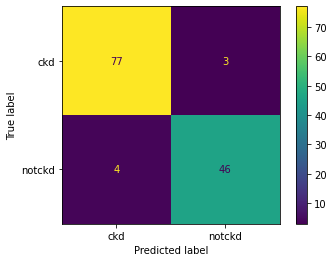

In [61]:
plot_confusion_matrix(logreg, X_test_sc, y_test, cmap = 'viridis');

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

**Answer:**
In the instance of diagnosing individuals in a hospital setting: it is better to wrongfully diagnose someone with a disease for which they seek further testing and treatement (and may be properly diagnosed in the process) rather than tell someone who is truly sick that they are healthy. As was reviewed in question 6., it is better to optimize for sensitivity/recall (the true positive rate). 

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [62]:
df['class'].value_counts(normalize = True)

ckd       0.625
notckd    0.375
Name: class, dtype: float64

**Answer:**
Unbalanced classes can be a problem because thoses classes that aren't well represented will not be properly accounted for in the model. In the case of this analysis, those individuals without CKD were under-represented: the split between those with CKD and those without was 62/38. With consideration to this fact, I did stratify my data about y when building my model.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

**Answer:**
I'd try to simplify the problem: suppose you're trying to model the predict dice rolls of a fair 6-sided die. Each potential instance is equally represented with a probability of 1/6. If we build a model around this all instances will have an equal 'weight' of 1/6. Suppose we have an unfair 6-sided side, where 1 occurs 1/2 the time and each other instance occurs 1/10. If we build a model to predict roles the instance of 1 could be potentially overcounted since it's weighted so much more heavily than the other occurrences.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [63]:
df['class'].value_counts()#normalize = True

ckd       250
notckd    150
Name: class, dtype: int64

In [66]:
df_maj = df[df['class'] == 'ckd']
df_maj['class'].value_counts()

ckd    250
Name: class, dtype: int64

In [67]:
df_maj.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd


In [68]:
df_maj.sample(n = 200_000, replace = True, random_state = 1)
df_maj.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd


In [69]:
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
#https://stackoverflow.com/questions/32752292/how-to-create-a-dataframe-of-random-integers-with-pandas

df_unbalanced = pd.DataFrame(df_maj.sample(n = 200_000, replace = True, random_state = 1))

In [70]:
df_unbalanced['class'].value_counts(normalize = True)

ckd    1.0
Name: class, dtype: float64

In [71]:
df_unbalanced = pd.concat([df_unbalanced, df[df['class'] == 'notckd']])

In [72]:
df_unbalanced['class'].value_counts(normalize = True)

ckd       0.999251
notckd    0.000749
Name: class, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [73]:
df_unbalanced.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
37,72.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,137.0,65.0,3.4,141.0,4.7,9.7,28.0,6900.0,2.5,yes,yes,no,poor,no,yes,ckd
235,45.0,70.0,1.01,2.0,0.0,NaN,normal,notpresent,notpresent,113.0,93.0,2.3,NaN,NaN,7.9,26.0,5700.0,NaN,no,no,yes,good,no,yes,ckd
140,69.0,70.0,1.01,0.0,4.0,NaN,normal,notpresent,notpresent,256.0,40.0,1.2,142.0,5.6,NaN,NaN,NaN,NaN,no,no,no,good,no,no,ckd


In [74]:
df_unbalanced['age'].isna().sum()

6414

In [76]:
df_unbalanced['age'].median()

59.0

In [77]:
df_unbalanced['age'].fillna(59, inplace = True)

In [78]:
X = df_unbalanced[['age']]
y = df_unbalanced['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [79]:
sc.fit(X_train)

StandardScaler()

In [80]:
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [81]:
logreg.fit(X_train_sc, y_train)

LogisticRegression(C=10, max_iter=10000)

In [82]:
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.9992538904284801, 0.9992405771613574)

In [83]:
preds_2 = logreg.predict(X_test_sc)

In [85]:
cm = confusion_matrix(y_test, preds_2)

In [86]:
cm_df = pd.DataFrame(cm, columns=['Pred No CKD', 'Pred CKD'], index=['No CKD', 'Actual CKD'])
cm_df

,Pred No CKD,Pred CKD
No CKD,50000,0
Actual CKD,38,0


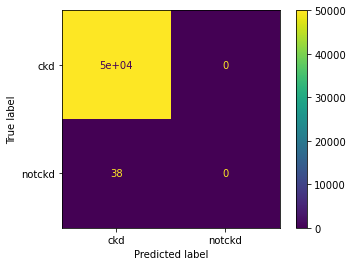

In [87]:
plot_confusion_matrix(logreg, X_test_sc, y_test, cmap = 'viridis');

- Typically, unbalanced classes are trouble for modeling because the model built will not properly account for instance of minority classes. In this instance both the false positives and true negatives are predicted to be 'zero', the denominator of 'specificity' would be 0 as well, which would mean specificity is undefined. 

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!